In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
from datetime import datetime
from pytz import timezone
import pytz

# Lectura y Ajuste de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
paths=sorted(glob.glob(r'/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Data/*.nc'))
paths
#Guardamos los xrdatasets en una lista
data_list=[]
for e in paths:
    data_list.append(xr.open_dataset(e))

In [4]:
#Corregir las longitudes: Pasar aquellas en -180° a 360°
#identificar la posicion de los dataset en -180°
neg_lon=[]
for i in range(len(data_list)):
    if np.mean(data_list[i].longitude.values)<0:
        neg_lon.append(i)

In [5]:
#Corregir a 360°
for n in neg_lon:
    data_list[n]=data_list[n].assign_coords(longitude=(data_list[n].longitude + 360))
    #print(data_list[n].longitude.values)

In [6]:
#Antes de agrupar se eliminan duplicados data_list[77]
data_list[77]=data_list[77].drop_duplicates(dim='time')

In [7]:
#Se combinan los datos en un unico dataset
data_set=xr.merge(data_list)
data_set


/usr/local/lib/python3.10/dist-packages/xarray/coding/variables.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:     (latitude: 4, longitude: 3, time: 15868, depth: 20)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64 12.72 12.8
  * longitude   (longitude) float64 278.3 278.4 278.5
  * time        (time) datetime64[ns] 2012-01-01T12:00:00 ... 2022-12-31T18:0...
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
Data variables:
    water_temp  (time, depth, latitude, longitude) float64 27.17 27.19 ... nan
    salinity    (time, depth, latitude, longitude) float64 35.91 35.85 ... nan

In [8]:
#Correccion de zona horaria ??????
#Zonas horarias
hycom_tz=pytz.timezone("GMT")
local_tz=pytz.timezone("America/Bogota")
new_time=[]
for i in range(len(data_set.time.data)):
    new_time.append(hycom_tz.localize(pd.to_datetime(data_set.time.data[i])).astimezone(local_tz).replace(tzinfo=None))
#new_time

# Promedio Trimestral

In [9]:
#Promedio trimestral multianual
ds_threemonthly = data_set.groupby("time.season").mean("time")
ds_threemonthly

<xarray.Dataset>
Dimensions:     (latitude: 4, longitude: 3, depth: 20, season: 4)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64 12.72 12.8
  * longitude   (longitude) float64 278.3 278.4 278.5
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    water_temp  (season, depth, latitude, longitude) float64 27.56 27.54 ... nan
    salinity    (season, depth, latitude, longitude) float64 35.96 35.96 ... nan

Text(0.5, 0.01, 'Tempertura [°C]')

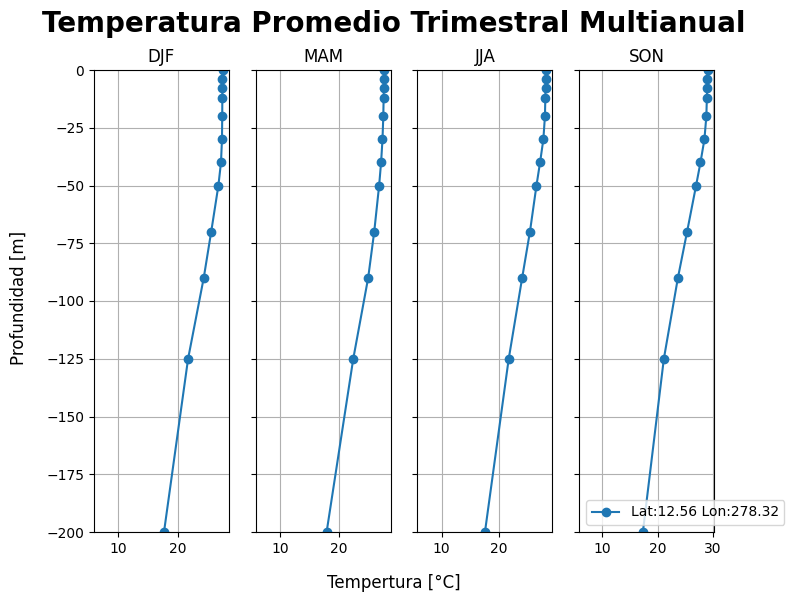

In [10]:
#Grafica de temperatura promedio trimestral
PlotT=ds_threemonthly.water_temp.isel(latitude=0,longitude=0)
#PlotT2=ds_threemonthly.water_temp.isel(latitude=1,longitude=1)
#PlotT3=ds_threemonthly.water_temp.isel(latitude=1,longitude=2)
#PlotT4=ds_threemonthly.water_temp.isel(latitude=3,longitude=0)
#PlotT5=ds_threemonthly.water_temp.isel(latitude=3,longitude=1)
#PlotT6=ds_threemonthly.water_temp.isel(latitude=3,longitude=2)
fig, axs = plt.subplots(1,4,figsize=(8,6),sharey=True)

axs[0].plot(PlotT[PlotT.season=='DJF'].values[0],-PlotT.depth, 
            label='Lat:'+str(np.round(PlotT.latitude.values,2))+' Lon:'+str(np.round(PlotT.longitude.values,2))
            , marker='o')
#axs[0].plot(PlotT2[PlotT2.season=='DJF'].values[0],-PlotT2.depth)
#axs[0].plot(PlotT3[PlotT3.season=='DJF'].values[0],-PlotT3.depth)
#axs[0].plot(PlotT4[PlotT4.season=='DJF'].values[0],-PlotT4.depth)
#axs[0].plot(PlotT5[PlotT5.season=='DJF'].values[0],-PlotT5.depth)
#axs[0].plot(PlotT6[PlotT6.season=='DJF'].values[0],-PlotT6.depth)
axs[0].set_title('DJF')
axs[0].grid()
#axs[0].legend()
#axs[0].set_xlabel('Temperatura [°C]')

axs[1].plot(PlotT[PlotT.season=='MAM'].values[0],-PlotT.depth, 
            label='Lat:'+str(np.round(PlotT.latitude.values,2))+' Lon:'+str(np.round(PlotT.longitude.values,2))
            , marker='o')
#axs[1].plot(PlotT2[PlotT2.season=='MAM'].values[0],-PlotT2.depth)
#axs[1].plot(PlotT3[PlotT3.season=='MAM'].values[0],-PlotT3.depth)
#axs[1].plot(PlotT4[PlotT4.season=='MAM'].values[0],-PlotT4.depth)
#axs[1].plot(PlotT5[PlotT5.season=='MAM'].values[0],-PlotT5.depth)
#axs[1].plot(PlotT6[PlotT6.season=='MAM'].values[0],-PlotT6.depth)
axs[1].set_title('MAM')
axs[1].grid()
#axs[1].legend()
#axs[1].set_xlabel('Temperatura [°C]')

axs[2].plot(PlotT[PlotT.season=='JJA'].values[0],-PlotT.depth, 
            label='Lat:'+str(np.round(PlotT.latitude.values,2))+' Lon:'+str(np.round(PlotT.longitude.values,2))
            , marker='o')
#axs[2].plot(PlotT2[PlotT2.season=='JJA'].values[0],-PlotT2.depth)
#axs[2].plot(PlotT3[PlotT3.season=='JJA'].values[0],-PlotT3.depth)
#axs[2].plot(PlotT4[PlotT4.season=='JJA'].values[0],-PlotT4.depth)
#axs[2].plot(PlotT5[PlotT5.season=='JJA'].values[0],-PlotT5.depth)
#axs[2].plot(PlotT6[PlotT6.season=='JJA'].values[0],-PlotT6.depth)
axs[2].set_title('JJA')
axs[2].grid()
#axs[2].legend()
#axs[2].set_xlabel('Temperatura [°C]')

axs[3].plot(PlotT[PlotT.season=='SON'].values[0],-PlotT.depth, 
            label='Lat:'+str(np.round(PlotT.latitude.values,2))+' Lon:'+str(np.round(PlotT.longitude.values,2))
            , marker='o')
#axs[3].plot(PlotT2[PlotT2.season=='SON'].values[0],-PlotT2.depth)
#axs[3].plot(PlotT3[PlotT3.season=='SON'].values[0],-PlotT3.depth)
#axs[3].plot(PlotT4[PlotT4.season=='SON'].values[0],-PlotT4.depth)
#axs[3].plot(PlotT5[PlotT5.season=='SON'].values[0],-PlotT5.depth)
#axs[3].plot(PlotT6[PlotT6.season=='SON'].values[0],-PlotT6.depth, marker='o')
axs[3].set_title('SON')
axs[3].grid()
axs[3].legend()
#axs[3].set_xlabel('Temperatura [°C]')

plt.ylim(bottom=-200,top=0)
fig.suptitle('Temperatura Promedio Trimestral Multianual',fontsize=20,fontweight ="bold")
fig.supylabel('Profundidad [m]')
fig.supxlabel('Tempertura [°C]')

Text(0.02, 0.5, 'Profundidad [m]')

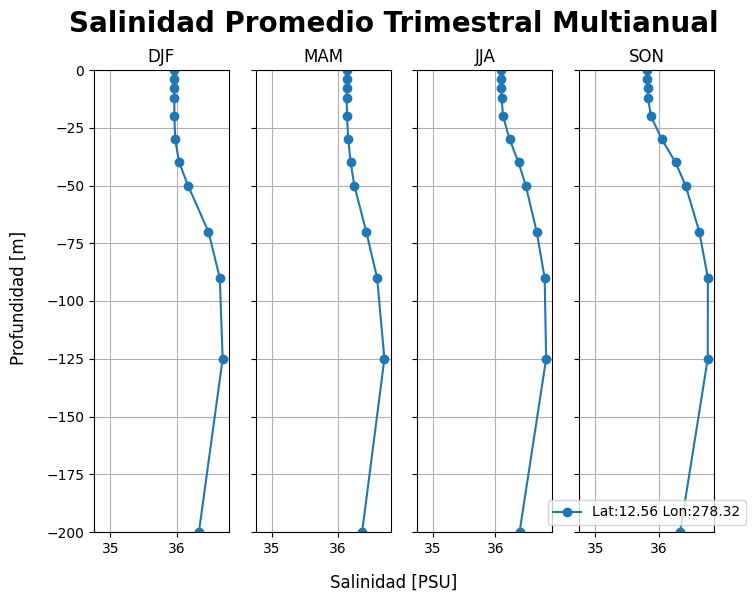

In [11]:
#Grafica de salinidad promedio trimestral
PlotS=ds_threemonthly.salinity.isel(latitude=0,longitude=0)
#PlotS2=ds_threemonthly.salinity.isel(latitude=1,longitude=1)
#PlotS3=ds_threemonthly.salinity.isel(latitude=1,longitude=2)
#PlotS4=ds_threemonthly.salinity.isel(latitude=3,longitude=0)
#PlotS5=ds_threemonthly.salinity.isel(latitude=3,longitude=1)
#PlotS6=ds_threemonthly.salinity.isel(latitude=3,longitude=2)
fig, axs = plt.subplots(1,4,figsize=(8,6),sharey=True)

axs[0].plot(PlotS[PlotS.season=='DJF'].values[0],-PlotS.depth, 
            label='Lat:'+str(np.round(PlotT.latitude.values,2))+' Lon:'+str(np.round(PlotT.longitude.values,2))
            , marker='o')
#axs[0].plot(PlotS2[PlotS2.season=='DJF'].values[0],-PlotS2.depth)
#axs[0].plot(PlotS3[PlotS3.season=='DJF'].values[0],-PlotS3.depth)
#axs[0].plot(PlotS4[PlotS4.season=='DJF'].values[0],-PlotS4.depth)
#axs[0].plot(PlotS5[PlotS5.season=='DJF'].values[0],-PlotS5.depth)
#axs[0].plot(PlotS6[PlotS6.season=='DJF'].values[0],-PlotS6.depth)
axs[0].set_title('DJF')
axs[0].grid()
#axs[0].legend()
#axs[0].set_xlabel('Salinidad [PSU]')

axs[1].plot(PlotS[PlotS.season=='MAM'].values[0],-PlotS.depth, 
            label='Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2))
            , marker='o')
#axs[1].plot(PlotS2[PlotS2.season=='MAM'].values[0],-PlotS2.depth)
#axs[1].plot(PlotS3[PlotS3.season=='MAM'].values[0],-PlotS3.depth)
#axs[1].plot(PlotS4[PlotS4.season=='MAM'].values[0],-PlotS4.depth)
#axs[1].plot(PlotS5[PlotS5.season=='MAM'].values[0],-PlotS5.depth)
#axs[1].plot(PlotS6[PlotS6.season=='MAM'].values[0],-PlotS6.depth)
axs[1].set_title('MAM')
axs[1].grid()
#axs[1].legend()
#axs[1].set_xlabel('Salinidad [PSU]')

axs[2].plot(PlotS[PlotS.season=='JJA'].values[0],-PlotS.depth, 
            label='Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2))
            , marker='o')
#axs[2].plot(PlotS2[PlotS2.season=='JJA'].values[0],-PlotS2.depth)
#axs[2].plot(PlotS3[PlotS3.season=='JJA'].values[0],-PlotS3.depth)
#axs[2].plot(PlotS4[PlotS4.season=='JJA'].values[0],-PlotS4.depth)
#axs[2].plot(PlotS5[PlotS5.season=='JJA'].values[0],-PlotS5.depth)
#axs[2].plot(PlotS6[PlotS6.season=='JJA'].values[0],-PlotS6.depth)
axs[2].set_title('JJA')
axs[2].grid()
#axs[2].legend()
#axs[2].set_xlabel('Salinidad [PSU]')

axs[3].plot(PlotS[PlotS.season=='SON'].values[0],-PlotS.depth, 
            label='Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2))
            , marker='o')
#axs[3].plot(PlotS2[PlotS2.season=='SON'].values[0],-PlotS2.depth)
#axs[3].plot(PlotS3[PlotS3.season=='SON'].values[0],-PlotS3.depth)
#axs[3].plot(PlotS4[PlotS4.season=='SON'].values[0],-PlotS4.depth)
#axs[3].plot(PlotS5[PlotS5.season=='SON'].values[0],-PlotS5.depth)
#axs[3].plot(PlotS6[PlotS6.season=='SON'].values[0],-PlotS6.depth)
axs[3].set_title('SON')
axs[3].grid()
axs[3].legend(loc='lower center')
#axs[3].set_xlabel('Salinidad [PSU]')

plt.ylim(bottom=-200,top=0)
fig.suptitle('Salinidad Promedio Trimestral Multianual',fontsize=20,fontweight ="bold")
fig.supxlabel('Salinidad [PSU]')
fig.supylabel('Profundidad [m]')
#fig.legend(loc='right')

Text(0.5, 0.98, 'Comparación trimestral - Lat:12.56 Lon:278.32')

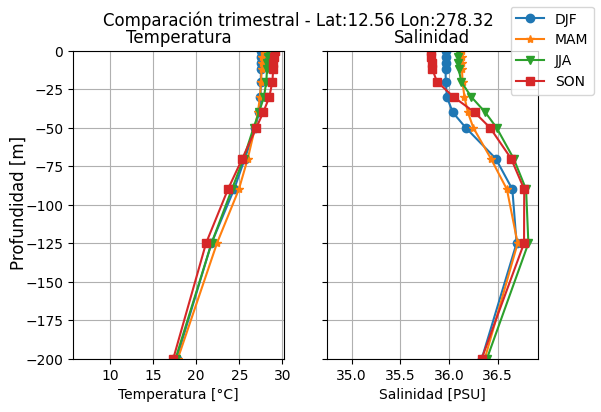

In [12]:
#Grafico comparativo entre trimestres
fig, axs =plt.subplots(1,2,figsize=(6,4),sharey=True)
axs[0].plot(PlotT[PlotT.season=='DJF'].values[0],-PlotT.depth,label='DJF', marker='o')
axs[0].plot(PlotT[PlotT.season=='MAM'].values[0],-PlotT.depth,label='MAM', marker='*')
axs[0].plot(PlotT[PlotT.season=='JJA'].values[0],-PlotT.depth,label='JJA', marker='v')
axs[0].plot(PlotT[PlotT.season=='SON'].values[0],-PlotT.depth,label='SON', marker='s')
axs[0].set_title('Temperatura')
axs[0].grid()
axs[0].set_xlabel('Temperatura [°C]')

axs[1].plot(PlotS[PlotS.season=='DJF'].values[0],-PlotS.depth, marker='o')
axs[1].plot(PlotS[PlotS.season=='MAM'].values[0],-PlotS.depth, marker='*')
axs[1].plot(PlotS[PlotS.season=='JJA'].values[0],-PlotS.depth, marker='v')
axs[1].plot(PlotS[PlotS.season=='SON'].values[0],-PlotS.depth, marker='s')
axs[1].set_title('Salinidad')
axs[1].grid()
axs[1].set_xlabel('Salinidad [PSU]')

plt.ylim(bottom=-200,top=0)
fig.supylabel('Profundidad [m]')
fig.legend(loc='upper right')
fig.suptitle('Comparación trimestral'+' - Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2)))


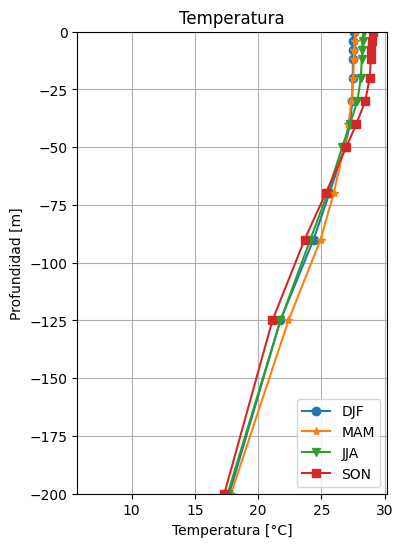

In [13]:
plt.figure(figsize=(4,6))
plt.plot(PlotT[PlotT.season=='DJF'].values[0],-PlotT.depth,label='DJF', marker='o')
plt.plot(PlotT[PlotT.season=='MAM'].values[0],-PlotT.depth,label='MAM', marker='*')
plt.plot(PlotT[PlotT.season=='JJA'].values[0],-PlotT.depth,label='JJA', marker='v')
plt.plot(PlotT[PlotT.season=='SON'].values[0],-PlotT.depth,label='SON', marker='s')
plt.title('Temperatura')
plt.grid()
plt.xlabel('Temperatura [°C]')
plt.ylim(bottom=-200,top=0)
plt.ylabel('Profundidad [m]')
plt.legend(loc='lower right')

#plt.suptitle('Comparación trimestral'+' - Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2)))

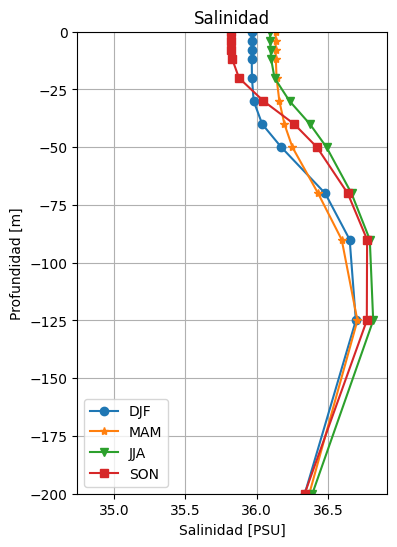

In [14]:
plt.figure(figsize=(4,6))
plt.plot(PlotS[PlotS.season=='DJF'].values[0],-PlotS.depth,label='DJF', marker='o')
plt.plot(PlotS[PlotS.season=='MAM'].values[0],-PlotS.depth,label='MAM', marker='*')
plt.plot(PlotS[PlotS.season=='JJA'].values[0],-PlotS.depth,label='JJA', marker='v')
plt.plot(PlotS[PlotS.season=='SON'].values[0],-PlotS.depth,label='SON', marker='s')
plt.title('Salinidad')
plt.grid()
plt.xlabel('Salinidad [PSU]')
plt.ylim(bottom=-200,top=0)
plt.ylabel('Profundidad [m]')
plt.legend(loc='lower left')

#plt.suptitle('Comparación trimestral'+' - Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2)))

(Text(0.5, 0, 'Temporada'), Text(0, 0.5, 'Profundidad [m]'))

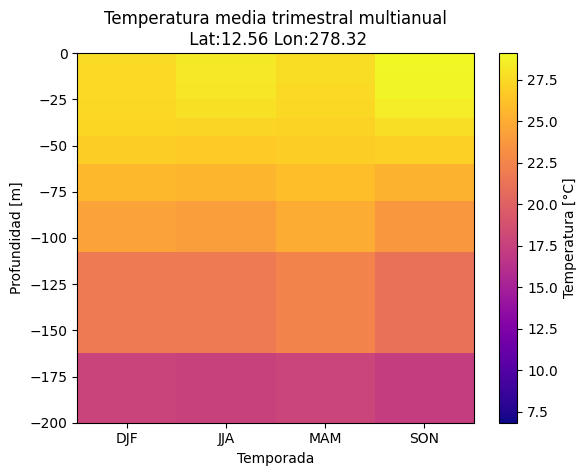

In [15]:
#Grafico en matriz de T trimestral
#Armar la matriz
mat_T_trim=[]
T_3monthly=ds_threemonthly.water_temp.isel(latitude=0,longitude=0)
for i in range(0,4):
  mat_T_trim.append(T_3monthly.isel(season=i).data)

#Coordenadas profundidad y mes
Depth=ds_threemonthly.depth.values
Temporada=ds_threemonthly.season.values
#Graficamos
plt.pcolormesh(Temporada,-Depth,np.array(mat_T_trim).transpose(),cmap='plasma')
plt.colorbar(label='Temperatura [°C]')
plt.ylim(top=0,bottom=-200)
plt.title('Temperatura media trimestral multianual'+'\n Lat:'+str(np.round(T_3monthly.latitude.data,2))+' Lon:'+str(np.round(T_3monthly.longitude.data,2)))
plt.xlabel('Temporada'), plt.ylabel('Profundidad [m]')

(Text(0.5, 0, 'Temporada'), Text(0, 0.5, 'Profundidad [m]'))

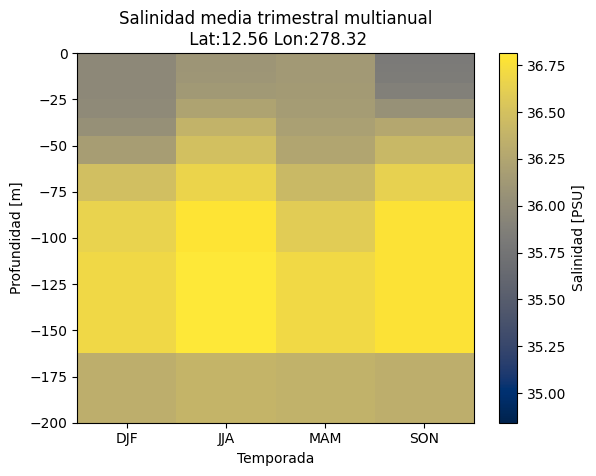

In [16]:
#Grafico en matriz de T trimestral
#Armar la matriz
mat_S_trim=[]
S_3monthly=ds_threemonthly.salinity.isel(latitude=0,longitude=0)
for i in range(0,4):
  mat_S_trim.append(S_3monthly.isel(season=i).data)

#Coordenadas profundidad y mes
Depth=ds_threemonthly.depth.values
Temporada=ds_threemonthly.season.values
#Graficamos
plt.pcolormesh(Temporada,-Depth,np.array(mat_S_trim).transpose(),cmap='cividis')
plt.colorbar(label='Salinidad [PSU]')
plt.ylim(top=0,bottom=-200)
plt.title('Salinidad media trimestral multianual'+'\n Lat:'+str(np.round(S_3monthly.latitude.data,2))+' Lon:'+str(np.round(S_3monthly.longitude.data,2)))
plt.xlabel('Temporada'), plt.ylabel('Profundidad [m]')

# Promedio Mensual Multianual

In [17]:
#Promedio mensual multianual
ds_monthly = data_set.groupby("time.month").mean("time")
ds_monthly

<xarray.Dataset>
Dimensions:     (latitude: 4, longitude: 3, depth: 20, month: 12)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64 12.72 12.8
  * longitude   (longitude) float64 278.3 278.4 278.5
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water_temp  (month, depth, latitude, longitude) float64 27.4 27.38 ... nan
    salinity    (month, depth, latitude, longitude) float64 36.0 36.0 ... nan

Text(0.02, 0.5, 'Profundidad [m]')

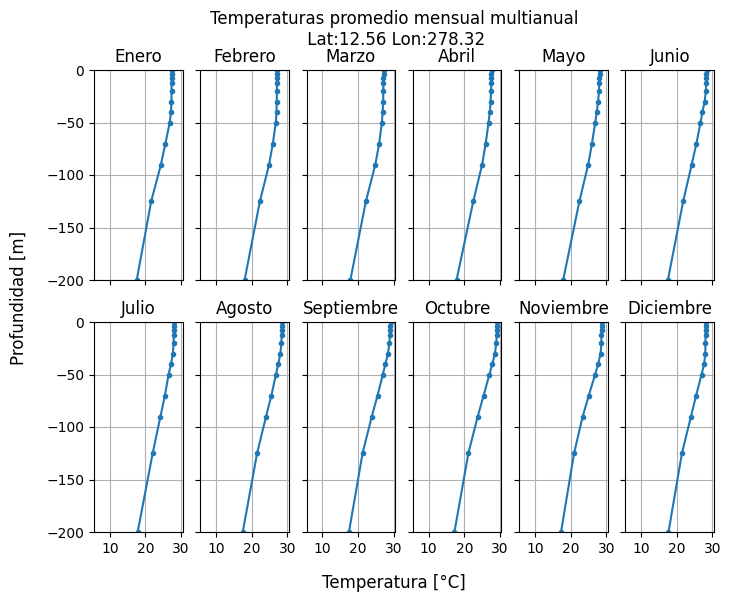

In [18]:
#Grafico media mensual multianual de temperatura
fig, axs = plt.subplots(2,6,figsize=(8,6),sharey=True,sharex=True)
nombre_meses=['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
for a in range(0,2):
    for b in range(1,7):
        axs[a][b-1].plot(ds_monthly.water_temp.isel(latitude=0,longitude=0)[ds_monthly.water_temp.month==b+a*6].values[0]
                      ,-ds_monthly.depth, marker='.')
        #axs[a][b-1].plot(ds_monthly.water_temp.isel(latitude=1,longitude=1)[ds_monthly.water_temp.month==b+a*6].values[0]
        #              ,-ds_monthly.depth)
        #axs[a][b-1].plot(ds_monthly.water_temp.isel(latitude=7,longitude=2)[ds_monthly.water_temp.month==b+a*6].values[0]
        #              ,-ds_monthly.depth)
        axs[a][b-1].grid()
        axs[a][b-1].set_title(nombre_meses[b-1+a*6])

plt.ylim(bottom=-200,top=0)
fig.suptitle('Temperaturas promedio mensual multianual'+'\n Lat:'+str(np.round(PlotT.latitude.values,2))+' Lon:'+str(np.round(PlotT.longitude.values,2)))
fig.supxlabel('Temperatura [°C]')
fig.supylabel('Profundidad [m]')

Text(0.02, 0.5, 'Profundidad [m]')

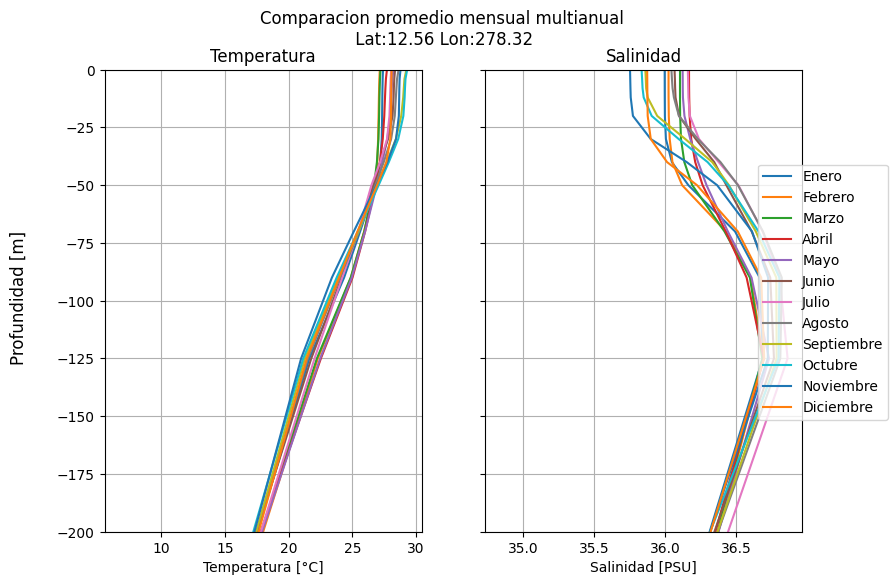

In [19]:
#Grafica comparativa de promedios mensuales multianuales
fig, axs = plt.subplots(1,2,figsize=(9,6),sharey=True)

for a in range(0,2):
    #print(a)
    if a==0:
        for b in range(1,13):
            axs[a].plot(ds_monthly.water_temp.isel(latitude=0,longitude=0)[ds_monthly.water_temp.month==b].values[0]
                      ,-ds_monthly.depth,label=str(nombre_meses[b-1]))
        axs[a].grid()
        axs[a].set_title('Temperatura')
        axs[a].set_xlabel('Temperatura [°C]')
    else:
        for b in range(1,13):
            axs[a].plot(ds_monthly.salinity.isel(latitude=0,longitude=0)[ds_monthly.water_temp.month==b].values[0]
                      ,-ds_monthly.depth)
        axs[a].grid()
        axs[a].set_title('Salinidad')
        axs[a].set_xlabel('Salinidad [PSU]')
plt.ylim(bottom=-200,top=0)
fig.legend(loc='right')
fig.suptitle('Comparacion promedio mensual multianual'+
             '\n Lat:'+str(np.round(PlotS.latitude.values,2))+
             ' Lon:'+str(np.round(PlotS.longitude.values,2)))
fig.supylabel('Profundidad [m]')

#Paleta de jet

In [20]:
#Grafico en matriz de T
#Armar la matriz
matrizT=[]
Tmonthly=ds_monthly.water_temp.isel(latitude=0,longitude=0)
for i in range(1,13):
  matrizT.append(Tmonthly.isel(month=i-1).data)
matrizT
#Coordenadas profundidad y mes
Depth=ds_monthly.depth.values
Meses=ds_monthly.month.values

(Text(0.5, 0, 'Tiempo [Mes]'), Text(0, 0.5, 'Profundidad [m]'))

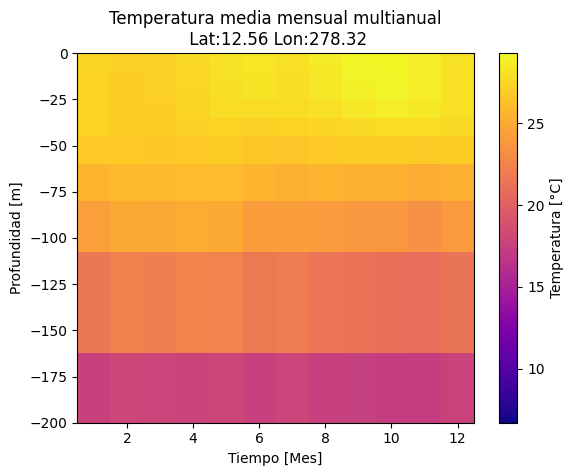

In [21]:
#Graficamos
plt.pcolormesh(Meses,-Depth,np.array(matrizT).transpose(),cmap='plasma')
plt.colorbar(label='Temperatura [°C]')
plt.ylim(top=0,bottom=-200)
plt.title('Temperatura media mensual multianual'+'\n Lat:'+str(np.round(Tmonthly.latitude.data,2))+' Lon:'+str(np.round(Tmonthly.longitude.data,2)))
plt.xlabel('Tiempo [Mes]'), plt.ylabel('Profundidad [m]')


(Text(0.5, 0, 'Tiempo [Mes]'), Text(0, 0.5, 'Profundidad [m]'))

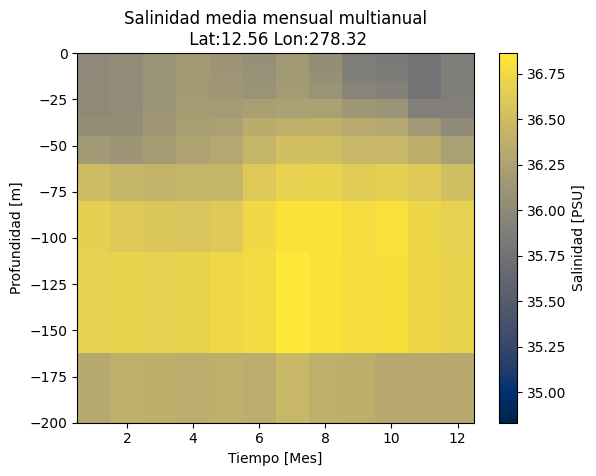

In [22]:
#Grafico en matriz de S
#Armar la matriz
matrizS=[]
Smonthly=ds_monthly.salinity.isel(latitude=0,longitude=0)
for i in range(1,13):
  matrizS.append(Smonthly.isel(month=i-1).data)
matrizS
#Coordenadas profundidad y mes
Depth=ds_monthly.depth.values
Meses=ds_monthly.month.values
#Graficamos
plt.pcolormesh(Meses,-Depth,np.array(matrizS).transpose(),cmap='cividis')
plt.colorbar(label='Salinidad [PSU]')
plt.ylim(top=0,bottom=-200)
plt.title('Salinidad media mensual multianual'+'\n Lat:'+str(np.round(Smonthly.latitude.data,2))+' Lon:'+str(np.round(Smonthly.longitude.data,2)))
plt.xlabel('Tiempo [Mes]'), plt.ylabel('Profundidad [m]')

# Promedio ENSO

In [23]:
#Cargar datos del indice del ONI
ONI=pd.read_excel('/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Data/ONI_NOAA.xlsx')
ONI
#Limite de +-0.5°C para condiciones de Niño y Niña
#Creamos la lista de condiciones de enso para cada fecha del dataset
enso_mode=[]
for i in range(len(data_set.time.values)):
    año=data_set.time.dt.year.values[i]
    mes=data_set.time.dt.month.values[i]
    if ONI[ONI['Year']==año][ONI.columns[mes]].values[0]<=-0.5:
        enso_mode.append('Niña')
    elif ONI[ONI['Year']==año][ONI.columns[mes]].values[0]>=0.5:
        enso_mode.append('Niño')
    else:
        enso_mode.append('Normal')


In [24]:
#Se establece como nueva coordenada los modos del enso.
data_set_enso=data_set.assign_coords(ENSO=('time',enso_mode))
data_set_enso

<xarray.Dataset>
Dimensions:     (latitude: 4, longitude: 3, time: 15868, depth: 20)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64 12.72 12.8
  * longitude   (longitude) float64 278.3 278.4 278.5
  * time        (time) datetime64[ns] 2012-01-01T12:00:00 ... 2022-12-31T18:0...
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
    ENSO        (time) <U6 'Niña' 'Niña' 'Niña' 'Niña' ... 'Niña' 'Niña' 'Niña'
Data variables:
    water_temp  (time, depth, latitude, longitude) float64 27.17 27.19 ... nan
    salinity    (time, depth, latitude, longitude) float64 35.91 35.85 ... nan

In [25]:
#Se establece la media para cada modo del enso
ds_enso = data_set_enso.groupby("ENSO").mean()
ds_enso_std = data_set_enso.groupby("ENSO").std()
ds_enso

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: Run

<xarray.Dataset>
Dimensions:     (latitude: 4, longitude: 3, depth: 20, ENSO: 3)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64 12.72 12.8
  * longitude   (longitude) float64 278.3 278.4 278.5
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * ENSO        (ENSO) object 'Niña' 'Niño' 'Normal'
Data variables:
    water_temp  (ENSO, depth, latitude, longitude) float64 28.16 28.15 ... nan
    salinity    (ENSO, depth, latitude, longitude) float64 35.95 35.95 ... nan

Text(0.02, 0.5, 'Profundidad [m]')

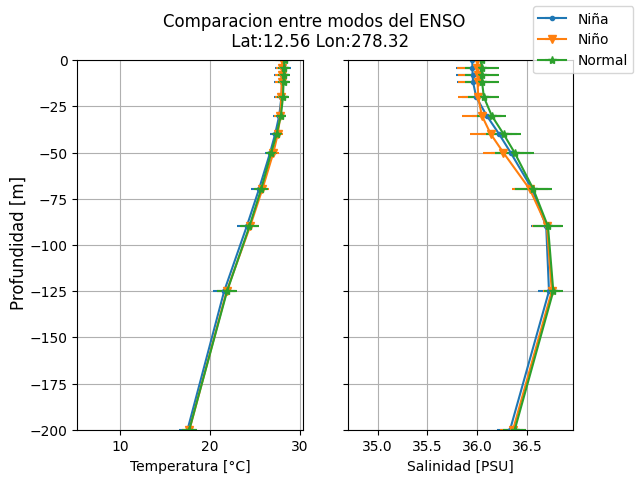

In [26]:
#Gráfica comparativa de entre cada modo del ENSO
fig, axs = plt.subplots(1,2,sharey=True)
markers=['.','v','*']
for i in range(0,2):
    if i==0:
        for e in range(0,3):
            axs[i].errorbar(ds_enso.water_temp.isel(latitude=0,longitude=0)
                        [ds_enso.water_temp.ENSO==ds_enso.water_temp.ENSO[e]].values[0],
                       -ds_enso.depth,
                       xerr=ds_enso_std.water_temp.isel(latitude=0,longitude=0)
                        [ds_enso.water_temp.ENSO==ds_enso.water_temp.ENSO[e]].values[0],
                        label=str(ds_enso.ENSO[e].values),
                        marker=markers[e])
        #axs[i].set_title('Temperatura')
        axs[i].set_xlabel('Temperatura [°C]')
        axs[i].grid()
    elif i==1:
        for e in range(0,3):
            axs[i].errorbar(ds_enso.salinity.isel(latitude=0,longitude=0)
                        [ds_enso.salinity.ENSO==ds_enso.salinity.ENSO[e]].values[0],
                       -ds_enso.depth,
                       xerr=ds_enso_std.salinity.isel(latitude=0,longitude=0)
                        [ds_enso.salinity.ENSO==ds_enso.salinity.ENSO[e]].values[0],
                        marker=markers[e])
        #axs[i].set_title('Salinidad')
        axs[i].set_xlabel('Salinidad [PSU]')
        axs[i].grid()

plt.ylim(bottom=-200,top=0)
fig.legend(loc='upper right')
fig.suptitle('Comparacion entre modos del ENSO'+
             ' \n Lat:'+str(np.round(PlotS.latitude.values,2))+
             ' Lon:'+str(np.round(PlotS.longitude.values,2)))
fig.supylabel('Profundidad [m]')

# Serie de Tiempo de T y S

In [27]:
serie_Tsup=data_set.water_temp.isel(latitude=0,longitude=0,depth=0)
serie_Ssup=data_set.salinity.isel(latitude=0,longitude=0,depth=0)

serie_T20=data_set.water_temp.isel(latitude=0,longitude=0,depth=4)
serie_S20=data_set.salinity.isel(latitude=0,longitude=0,depth=4)

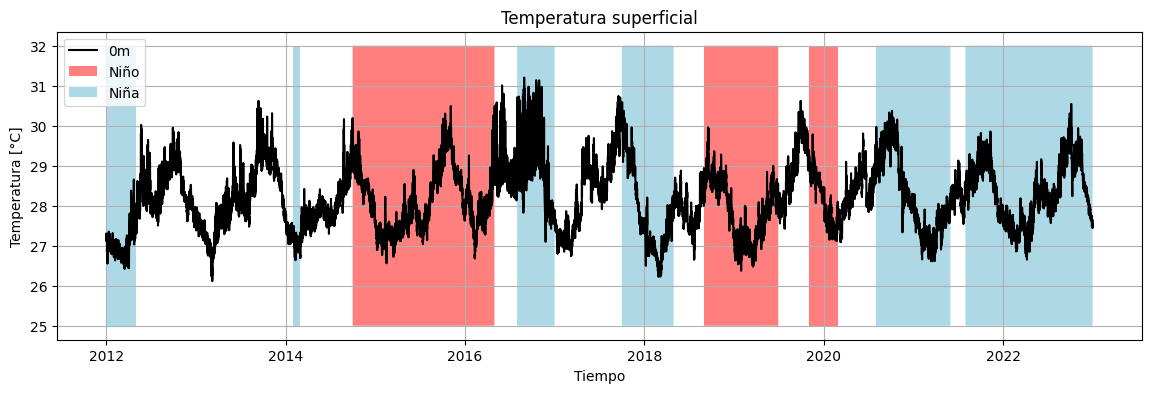

In [28]:
#Grafica serie de temperatura superficial
plt.figure(figsize=(14,4))
plt.plot(serie_Tsup.time, serie_Tsup.values, label='0m', color='black')
#plt.plot(serie_T20.time, serie_T20.values, label='20m', color='yellow')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura [°C]')
plt.title('Temperatura superficial')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

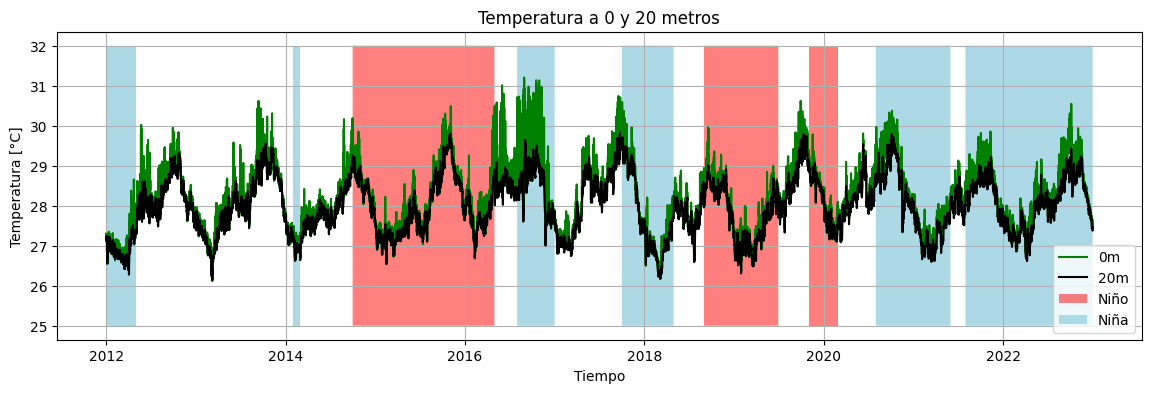

In [29]:
#Grafica serie de temperatura a 20m
plt.figure(figsize=(14,4))
plt.plot(serie_Tsup.time, serie_Tsup.values, label='0m', color='green')
plt.plot(serie_T20.time, serie_T20.values, label='20m', color='black')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura [°C]')
plt.title('Temperatura a 0 y 20 metros')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

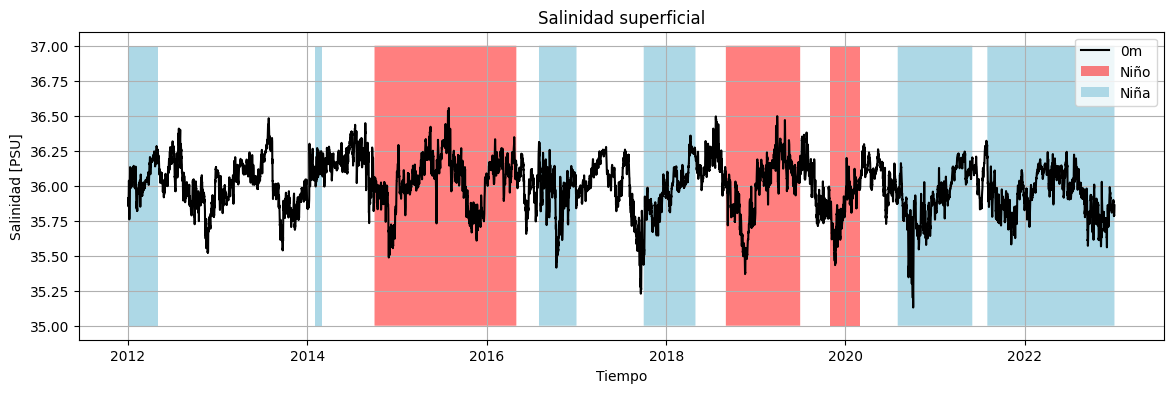

In [30]:
#Grafica serie de salinidad superficial
plt.figure(figsize=(14,4))
plt.plot(serie_Ssup.time, serie_Ssup.values, label='0m', color='black')
#plt.plot(serie_S20.time, serie_S20.values, label='20m')
plt.xlabel('Tiempo')
plt.ylabel('Salinidad [PSU]')
plt.title('Salinidad superficial')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

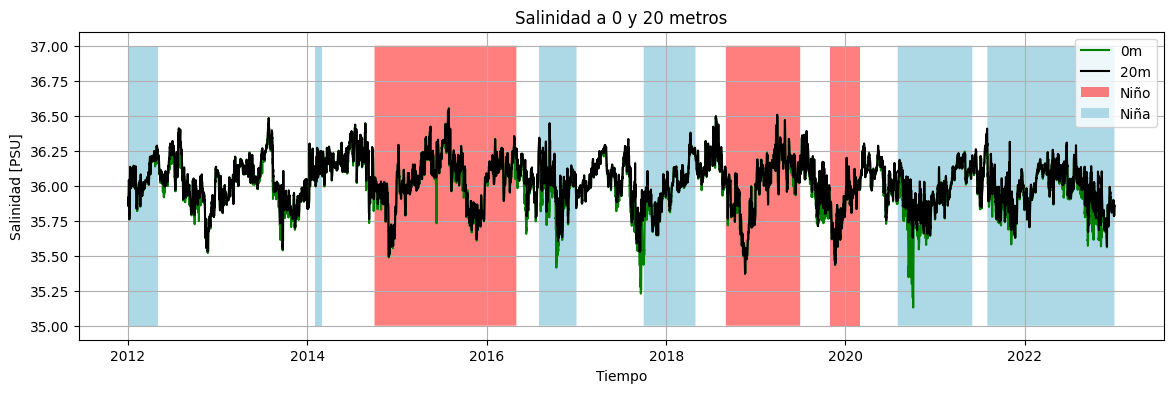

In [31]:
#Grafica serie de salinidad a 20m
plt.figure(figsize=(14,4))
plt.plot(serie_Ssup.time, serie_Ssup.values, label='0m', color='green')
plt.plot(serie_S20.time, serie_S20.values, label='20m', color='black')
plt.xlabel('Tiempo')
plt.ylabel('Salinidad [PSU]')
plt.title('Salinidad a 0 y 20 metros')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

# Promedio de regimen de lluvias seco y humedo

In [32]:
#Crear una coordenada que identifique las epoca
epoca=[]

for i in range(len(data_set.time.values)):
  if data_set.time.dt.month.values[i] >=1 and data_set.time.dt.month.values[i] <=4:
    epoca.append('Seco')
  else:
    epoca.append('Humedo')

In [33]:
#Se añade la nueva coordenada
ds_regimen=data_set.assign_coords(regimen=('time',epoca))
ds_regimen
#Se promedia segun el regimen
ds_regimen_std=ds_regimen.groupby("regimen").std()
ds_regimen=ds_regimen.groupby("regimen").mean()

ds_regimen

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset>
Dimensions:     (latitude: 4, longitude: 3, depth: 20, regimen: 2)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64 12.72 12.8
  * longitude   (longitude) float64 278.3 278.4 278.5
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * regimen     (regimen) object 'Humedo' 'Seco'
Data variables:
    water_temp  (regimen, depth, latitude, longitude) float64 28.58 ... nan
    salinity    (regimen, depth, latitude, longitude) float64 35.97 ... nan

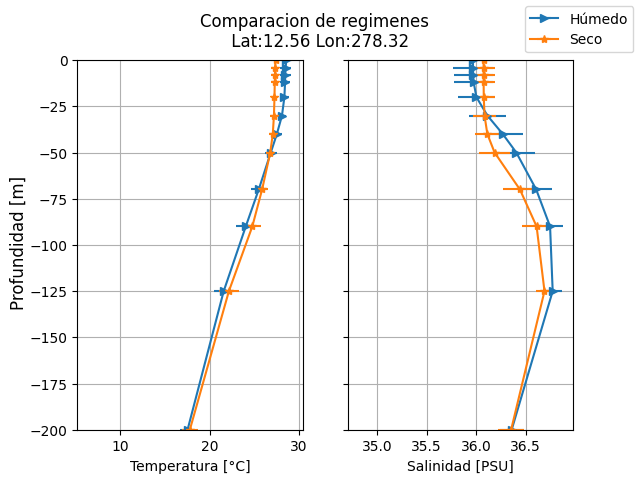

In [34]:
#Grafico comparativo

fig, axs = plt.subplots(1,2,sharey=True)

axs[0].errorbar(ds_regimen.water_temp.isel(latitude=0,longitude=0,regimen=0).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.water_temp.isel(latitude=0,longitude=0,regimen=0).values
            , label='Húmedo', fmt='->')
axs[0].errorbar(ds_regimen.water_temp.isel(latitude=0,longitude=0,regimen=1).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.water_temp.isel(latitude=0,longitude=0,regimen=1).values
            , label='Seco', fmt='-*')
axs[0].grid()
axs[0].set_xlabel('Temperatura [°C]')

axs[1].errorbar(ds_regimen.salinity.isel(latitude=0,longitude=0,regimen=0).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.salinity.isel(latitude=0,longitude=0,regimen=0).values
            , fmt='->')
axs[1].errorbar(ds_regimen.salinity.isel(latitude=0,longitude=0,regimen=1).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.salinity.isel(latitude=0,longitude=0,regimen=1).values
            , fmt='-*')
axs[1].grid()
axs[1].set_xlabel('Salinidad [PSU]')

plt.ylim(top=0, bottom=-200)
fig.suptitle('Comparacion de regimenes'+
             ' \n Lat:'+str(np.round(ds_regimen.latitude.values[0],2))+
             ' Lon:'+str(np.round(ds_regimen.longitude.values[0],2)))
fig.supylabel('Profundidad [m]')
fig.legend()

# Comparación con AWAC 600

In [35]:
#Leer los datos
path_AW=glob.glob(r'/content/drive/MyDrive/MODELO_NUMERICO/DATOS_CAMPO/DATOS_SAI_4_15_nov_2021/AWAC600/*.sen')
path_AW
def temperature_surface(path:str):
        func_date = lambda x: datetime.strptime(x, "%Y %m %d %H %M")
        df_press = pd.read_csv(f'{path}',delimiter='\s+', usecols=[0,1,2,3,4,14], 
                               names=["Month","Day","Year","Hour",'Minute','Temp'], 
                                parse_dates={'Time':['Year','Month', 'Day', 'Hour', 'Minute']}, 
                                date_parser=func_date).set_index('Time')
        #df_press = df_press[ini_date:end_date]
        #df_press['Temp'] = df_press['Temp'] - df_press['Temp'].mean()
        return df_press[['Temp']]
Temp_AW=temperature_surface(path_AW[0])

In [36]:
Temp_AW['2021-11-06 11:00:00':'2021-11-14 05:00:00']

,Temp
Time,
2021-11-06 11:17:00,29.72
2021-11-06 11:47:00,29.58
2021-11-06 12:17:00,29.59
2021-11-06 12:47:00,29.57
2021-11-06 13:17:00,29.56
...,...
2021-11-14 02:47:00,29.33
2021-11-14 03:17:00,29.33
2021-11-14 03:47:00,29.32


(28.0, 30.0)

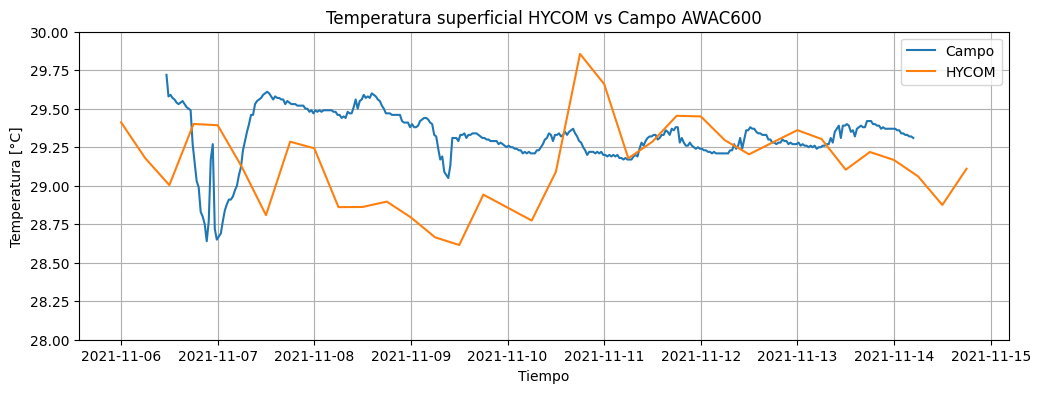

In [37]:
#Separar los datos de HYCOM
# 6 a las 11am  hasta el 14 a 5am
Temp_sup_HYCOM=data_set.water_temp.isel(latitude=0,longitude=0,depth=0).sel(time=slice('2021-11-6','2021-11-14'))
plt.figure(figsize=(12,4))
plt.plot(Temp_AW['2021-11-06 11:00:00':'2021-11-14 05:00:00'],label='Campo')
plt.plot(Temp_sup_HYCOM.time,Temp_sup_HYCOM,label='HYCOM')
plt.grid(), plt.legend()
plt.title('Temperatura superficial HYCOM vs Campo AWAC600')
plt.xlabel('Tiempo'), plt.ylabel('Temperatura [°C]')
plt.ylim(bottom=28,top=30)

# Ubicación en batimetria

In [38]:
!pip install mat73
!pip install pyproj
!pip install svgpathtools
!pip install svgpath2mpl
!pip install netCDF4
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━

In [39]:
#mas librerias
import matplotlib as mpl
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pyproj import Proj
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from netCDF4 import Dataset, num2date
import missingno as msno
import re 
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [40]:
#funciones
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    -----------------------------------------------------------
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    ----------------------------------------------------------
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

def read_grid_file_d3d(num_btw_lines:int, ncols:int, nrows:int, path:str, name_file_grid:str, name_file_deep:str):
    """
    This function read the data from .grd file obtened of d3d
    --------------------------------------------------------------------
    Input:
    - num_btw_lines: cantidad de lineas entre cada eta
    - nrows: numéro de filas del archivo
    - ncols: numéro de columnas del archivo
    - path: ruta del archivo
    - name_file_grid:nombre del archivo
    --------------------------------------------------------------------
    Output: 
    - dic_ : diccionario donde cada llave es una fila y contine 
    las respectivas coordendas que deben ser iguales al numero de columnas 
    """
    patron_eta = r'\b\w+=\s*\d+'
    patron_num =  r'\d+\.\d+E[+-]?\d+'

    with open(f'{path}/{name_file_grid}', 'r') as f:
        contenido = f.read ()
    keys_dic = re.findall(patron_eta, contenido)

    with open(f'{path}/{name_file_grid}', 'r') as f:
        lineas = f.readlines()

    dic_ = {}
    for j, key in enumerate (keys_dic):
        list_ = []
        for i, linea in enumerate(lineas):
            eta = re.findall(patron_eta, linea)
            try:
                if  key == eta[0]:
                    nums_linea = re.findall(patron_num, linea)
                    for nu in nums_linea:
                        list_.append(float(nu))
                    for k in range (1, num_btw_lines):
                        nums_linea_plus = re.findall(patron_num, lineas[i+k])
                        for num in nums_linea_plus:
                            list_.append(float(num))             
            except: 
                pass
        arr= np.array(list_).reshape((ncols-1, 2), order = 'F') 
        dic_.update({key:pd.DataFrame({'X': arr[:,0], 'Y': arr[:,1]})})
    
    patron_num =  r'[-+]?\d+\.\d+E[+-]?\d+'
    with open(f'{path}/{name_file_deep}', 'r') as f:
        contenido = f.read ()
    deep = re.findall(patron_num, contenido)
    Z = []
    for z in deep:
        Z.append(float(z))
    Z = np.array(Z).reshape((nrows, ncols))
    Z[Z<0] = np.nan
    # Z = Z[:-1, :-1]


    X = np.zeros(shape = (nrows-1, ncols-1))
    Y = np.zeros(shape = (nrows-1, ncols-1))
    for i, key in enumerate(list(dic_.keys())):
        X[i, :] = dic_[key]['X']
        Y[i, :] = dic_[key]['Y']

    return X,Y, Z

def read_coast_line (path:str, name_file:str):
    """
    Esta función lee los datos de la linea de costa de un archivo .mat (v6)
    -------------------------------------------------------------------------
    Input:
    - path: ruta del archivo
    - name_file: nombre del archivo
    -------------------------------------------------------------------------
    Output:
    - Data Frame de la linea dosta
    """
    data_dir = pjoin(dirname(sio.__file__), path) # Definir Ruta
    mat_fname = pjoin(data_dir, name_file)     # Econtrar el archivo
    data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
    xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
    lc  = np.column_stack((xlc,ylc))
    df_lc = pd.DataFrame({'X':lc[:,0], 'Y':lc[:,1] })
    return df_lc

def bat_figure(df_lc:pd.DataFrame, X:np.array, Y:np.array, Z:np.array,delta_lim:float ,delta:float, active_puntos_obs: bool,size:tuple = (7, 5.5), df_ind = None, bottom_legend = None):
    """Función para graficar la malla orientada
    -------------------------------------------------------------------------------------------------
    Input: 
    - df_lc: linea de costa
    - X: arreglo en dos o una dimensión de la malla (dirección x)
    - Y: arreglo en dos o una dimensión de la malla (dirección y)
    - Z: arreglo de las profundidades, las dimesiones deben corresponder con las dimensiones de X y Y
    - size: tupla de las dimensiones de la figura
    - delta: delta para ubicar el norte respecto a la esquina superior derecha (se resta)
    - delta_lim: limites de la figura
    -------------------------------------------------------------------------------------------------
    Output:
    - Figure 

    """

    fig, ax = plt.subplots(figsize = size)
    colormap = cm.Blues
    levels = list(np.round(np.nanmax(Z)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 100])/100,0))
    pc = ax.contourf(X, Y, Z,levels = levels,cmap=colormap)
    cb=plt.colorbar(pc)
    a = ax.contour(X, Y, Z,colors="gray",levels=levels,\
                    linewidths=0.2)
    labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
    ax.set_xlabel ('E [m]',size=13, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=13, fontweight = 'semibold')
    if (X.min() < df_lc['X'].min()) | (Y.min() < df_lc['Y'].min()):
            ax.set_xlim([X.min() - delta_lim, X.max() + delta_lim])
            ax.set_ylim([Y.min()- delta_lim, Y.max() + delta_lim])
    else:
        ax.set_xlim([df_lc['X'].min(), X.max() + delta_lim])
        ax.set_ylim([df_lc['Y'].min(), Y.max() - delta_lim])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cb.set_label('Depth [m]',size=13, fontweight = 'semibold')
    cb.set_ticklabels(cb.get_ticks(),size=10)
    fig_params(ax)
    fig.suptitle("Bathymetry", size = 13, fontweight = 'semibold')     # Titulo de la figura
    ax.set_title('San Andrés Island',size = 13, fontweight = 'semibold')   # Subtítulo de la figura
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)

    try:
      brujula_path, attributes = svg2paths('/content/drive/MyDrive/MODELO_NUMERICO/BASES_DE_DATOS/CLIMATOLOGIA_HYCOM/Scripts/brujula.svg')
    except: 
      brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)


    fig.tight_layout()
    plt.xticks(rotation = 20)
    plt.grid(False)



def df_project_grid_grid(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X':X[:,0], 'Y':Y[:,0]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}),
                    pd.DataFrame({'X':X[:,n_cols-2], 'Y':Y[:,n_cols-2]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[0,:], 'Y':Y[0,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[n_rows-2,:], 'Y':Y[n_rows-2,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]})]).reset_index(drop=True)
    
    fun_coords = lambda x: coord_wgs(df_bat.iloc[x,0], df_bat.iloc[x,1])
    coords_bat = list(map(fun_coords, df_bat.index))
    df_bat['lon'] = list(map(lambda x: coords_bat[x][0], df_bat.index))
    df_bat['lat'] = list(map(lambda x: coords_bat[x][1], df_bat.index))

    return df_bat

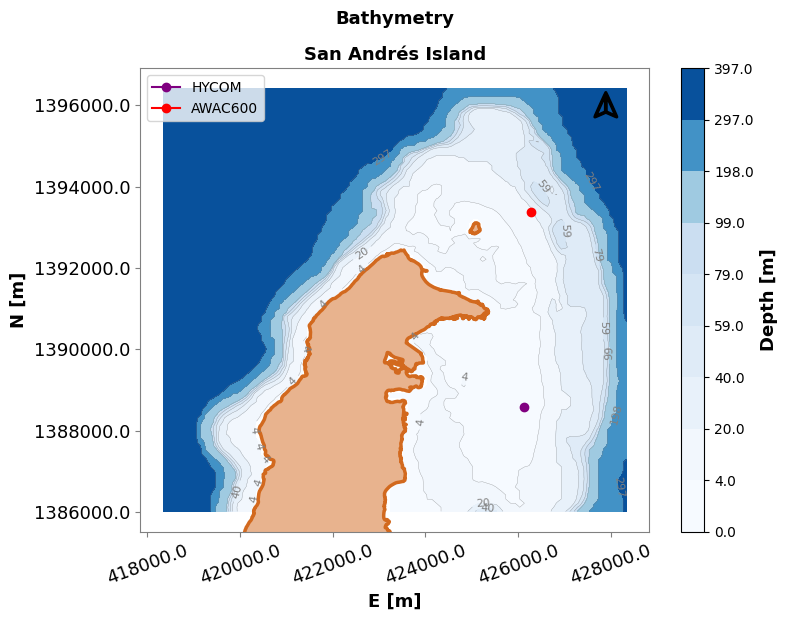

In [41]:
path_bat = r"/content/drive/MyDrive/MODELO_NUMERICO/BATIMETRIA/BAT_NORTE_RECTANGULAR_100m"
# path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
# path = r'C:\Users\paula\Desktop\BAT_SAI_NORTE_3D_V2'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

# num_lineas = 31
# n_rows = 238 #83
# n_cols = 155

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path_bat, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path_bat, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

#Ubicamos el punto de Hycom y del AWAC600
HYCOM=[-81.679993, 12.560000]
HYCOM_xy=proj_ZONE17(HYCOM[0],HYCOM[1])
AWAC600=[-81.678766, 12.603483]
AWAC600_xy=proj_ZONE17(AWAC600[0],AWAC600[1])
plt.plot(HYCOM_xy[0],HYCOM_xy[1], marker='o', color='purple',label='HYCOM')
plt.plot(AWAC600_xy[0],AWAC600_xy[1], marker='o', color='red', label='AWAC600')
plt.legend()

# Promedio mensual multianual por horas (entre el 5 y 28 de cada mes)


In [45]:
#Se desea crear un cronograma promedio multianual para cada mes para los dias entre el 5-28
#Se trabaja con 4 puntos
ds_cronoprom=data_set.sel(latitude=[12.56,12.64],longitude=[278.320007,278.4], method='nearest')
#se seleccionan solo los registros de tiempo donde el dia este entre o sea igual a 5 al 28
#ds_cronoprom=ds_cronoprom.where(ds_cronoprom.time.dt.day>=5,drop=True).where(ds_cronoprom.time.dt.day<=28,drop=True)
#Iteraremos entre todos los meses y haremos groupby por horas, guardamos en una lista cada mes, y añadimos dimension que indique el mes
cronoprom_list=[]
for i in range(1,13):
  #print(i)
  cronoprom_list.append(ds_cronoprom.where(ds_cronoprom.time.dt.month==i,drop=True).groupby('time.hour').mean().expand_dims(dim={'month':[i]}))
#juntamos en un unico dataset
ds_cronoprom=xr.merge(cronoprom_list)
ds_cronoprom

<xarray.Dataset>
Dimensions:     (latitude: 2, longitude: 2, depth: 20, hour: 8, month: 12)
Coordinates:
  * latitude    (latitude) float64 12.56 12.64
  * longitude   (longitude) float64 278.3 278.4
  * depth       (depth) float64 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * hour        (hour) int64 0 3 6 9 12 15 18 21
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water_temp  (month, hour, depth, latitude, longitude) float64 27.43 ... nan
    salinity    (month, hour, depth, latitude, longitude) float64 35.98 ... nan

(Text(0.5, 0, 'Temperatura [°C]'), Text(0, 0.5, 'Profundidad [m]'))

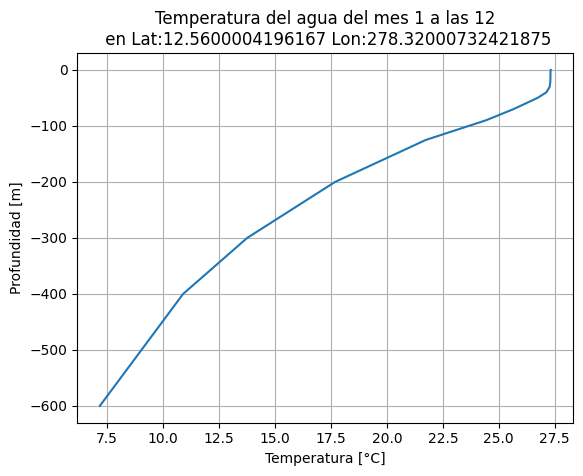

In [59]:
#Grafica prueba
plot1=ds_cronoprom.sel(latitude=12.56,longitude=278.320007,month=1,hour=12, method='nearest').water_temp
plt.plot(plot1,-plot1.depth),plt.grid()
plt.title('Temperatura del agua del mes '+str(plot1.month.values)+' a las '+str(plot1.hour.values)+
          '\n en Lat:'+str(plot1.latitude.values)+' Lon:'+str(plot1.longitude.values))
plt.xlabel('Temperatura [°C]'), plt.ylabel('Profundidad [m]')
